# Topic Extraction - latent dirichlet allocation

We will proceed to use LDA as for topic extraction.
LDA is a generative method that fits the most likely parameters of a simulated distribution of words over documents.  
It models a distribution of topics over reviews, and of words over topics. This way, we may observe the likelihood of the words that belong to each topic (they may be shared) and infer the meaning of the topic.  
Its important to note that topics may not have a clear meaning, and it may even capture only noise.

In [1]:
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
import spacy
from spacy.lang.en import English
import numpy as np
import pandas as pd
from random import shuffle
import pickle
import string
import re
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore

In [2]:
# Load data
X_train = pd.read_csv('data/X_train.csv', header=None, names=['text'])
X_train['text'] = X_train['text'].apply(lambda text: re.sub('\n', '', text))
X_test = pd.read_csv('data/X_test.csv', header=None, names=['text'])
X_test['text'] = X_test['text'].apply(lambda text: re.sub('\n', '', text))
Y_train = pd.read_csv('data/Y_train.csv', header=None, names=['label'])
Y_test = pd.read_csv('data/Y_test.csv', header=None, names=['label'])

In [3]:
#Divide data
train_neg = X_train[Y_train['label'] == 'negative']
train_pos = X_train[Y_train['label'] == 'positive']
train_neg.head()

,text
11,This is my first visit to this Kneaders and it...
23,4 Stars for being a Packers Bar - 1 star for c...
24,Two peopleOrder 1: Philly Cheesesteak: $14 - Y...
25,I am a fan of spicy ramen but was a huge disap...
28,We went to this restaurant a couple of times a...


In [4]:
# We will use punctuations to filter out useless simbols.
# Parser wil let create lemmas from the words.
punctuations = string.punctuation
parser = English()

# Cleaner will be user to remove trailing whitespaces and lowercase the texts
class cleaner(TransformerMixin):
    def transform(self, X, **transform_params):
        res = [text.strip().lower() for text in X.text]
        return res

    def fit(self, X, y=None, **fit_params):
        return self
# Tokenize wil be used to lemmatize the words, remove pronouns, punctuations and stop words.
class tokenizer(TransformerMixin):
    def transform(X,parser=parser, **transform_params):
        reviews = []
        for text in X:
            parsedText = parser(text)
            token_list = []
            for token in parsedText:
                if token.lemma_ != "-PRON-":
                    if (token.is_stop == False) & (token.lemma_ not in punctuations) & (token.lemma_ != ' '):
                        token_list.append(token.lemma_)
            reviews.append(token_list)
        return reviews
    
    def fit(self, X, y=None, **fit_params):
        return self
to_tokens = Pipeline([("cleaner", cleaner()),('tokenize', tokenizer)])

# Negative reviews corpora
#train_neg_tokens = to_tokens.transform(train_neg)
#neg_dictionary = Dictionary(train_neg_tokens)
#neg_corpus = [neg_dictionary.doc2bow(text) for text in train_neg_tokens]

# Positive reviews corpora
train_pos_tokens = to_tokens.transform(train_pos)
pos_dictionary = Dictionary(train_pos_tokens)
pos_corpus = [pos_dictionary.doc2bow(text) for text in train_pos_tokens]

# Gridsearch

We proceed to do a gridsearch over LDA
We will evaluate the results using coherence.

#### Since there is a tight time constraint, we will not do an exhaustive parameter space search. We will focus on showing the process of optimizing the models. It is very probable that we will arrive at overfited models or suboptimal parameters.

In [119]:
# supporting function
def get_coherence(corpus, lemmatized_data, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=91,
                                           chunksize=2000,
                                           passes=100,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_data, corpus=corpus, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [129]:
# Topics range
topics_range = [10]
# Alpha parameter
#alpha = [0.01,0.1]
alpha = [0.8]
# Beta parameter
beta = [0.8,0.6]
#model_results = {'Topics': [],'Alpha': [],'Beta': [],'Coherence': []}

# iterate through number of topics
for k in topics_range:
    # iterate through alpha values
    for a in alpha:
        # iterare through beta values
        for b in beta:
            # get the coherence score for the given parameters
            cv = get_coherence(corpus=neg_corpus, lemmatized_data=train_neg_tokens, dictionary=neg_dictionary, k=k, a=a, b=b)
            # Save the model results
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)
            print(k,a,b,cv)

10 0.8 0.8 0.4409393303589663
10 0.8 0.6 0.4396687186972977


In [130]:
pd.DataFrame(model_results).to_csv('lda_search.csv', index=False)
pd.read_csv('lda_search.csv').sort_values('Coherence')

,Topics,Alpha,Beta,Coherence
15,20,0.01,symmetric,0.342127
13,20,0.01,0.05,0.342127
21,20,0.1,0.05,0.346137
19,20,0.05,symmetric,0.350471
17,20,0.05,0.05,0.350471
...,...,...,...,...
59,17,0.8,0.8,0.501632
55,15,0.8,0.8,0.511299
65,18,0.8,0.6,0.515889
66,18,0.8,0.8,0.516444


### Coherence is low and more searching should be done, bute we will stop it here given the time constraint.

## Negative comments

Its difficult to find a clear topic with this amount of training, but we can see that topic 8 may be talking about customer service.

In [5]:
#Build best model
lda_model = gensim.models.LdaMulticore(corpus=neg_corpus,
                                       id2word=neg_dictionary,
                                       num_topics=10, 
                                       random_state=91,
                                       chunksize=2000,
                                       passes=100,
                                       alpha=0.1,
                                       eta=0.8,
                                       per_word_topics=True)

In [6]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, neg_corpus, dictionary=lda_model.id2word)
vis

/home/fer/anaconda3/envs/froneus/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.290318  0.122264       1        1  28.084532
0      0.280241 -0.151593       2        1  27.917746
9      0.304255 -0.003277       3        1  22.494839
2      0.254586  0.031669       4        1  18.863737
5     -0.186376  0.029849       5        1   1.132995
1     -0.191278 -0.016190       6        1   0.443700
4     -0.187591 -0.006001       7        1   0.365317
8     -0.188759 -0.000799       8        1   0.346101
7     -0.187750 -0.002937       9        1   0.178717
3     -0.187648 -0.002985      10        1   0.172322, topic_info=      Category          Freq    Term         Total  loglift  logprob
13     Default  56884.000000    food  56884.000000  30.0000  30.0000
1281   Default   7538.000000     car   7538.000000  29.0000  29.0000
27     Default  52920.000000   order  52920.000000  28.0000  28.0000
340    Default  30671.000000    wait  30671.000000  27.0000  27.0000
25     Default  23718.000000  minute  23718.000000  26.0000  26.0000
...        ...           ...     ...           ...      ...      ...
10176  Topic10      0.332344   c'est     20.045372   2.2640 -10.4406
3303   Topic10      0.346915  london     43.873848   1.5236 -10.3977
27669  Topic10      0.320116      es     18.483734   2.3076 -10.4781
38780  Topic10      0.315384      te     22.165911   2.1110 -10.4930
2206   Topic10      0.351157    mark   1187.742432  -1.7628 -10.3855

[630 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
66976      1  0.043201  \r\r
66976      2  0.043201  \r\r
66976      3  0.820817  \r\r
66976      4  0.043201  \r\r
5429       1  0.174866   --i
...      ...       ...   ...
19833      1  0.173966     ！
19833      2  0.173966     ！
19833      3  0.173966     ！
19833      4  0.173966     ！
19833     10  0.173966     ！

[2460 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 10, 3, 6, 2, 5, 9, 8, 4])

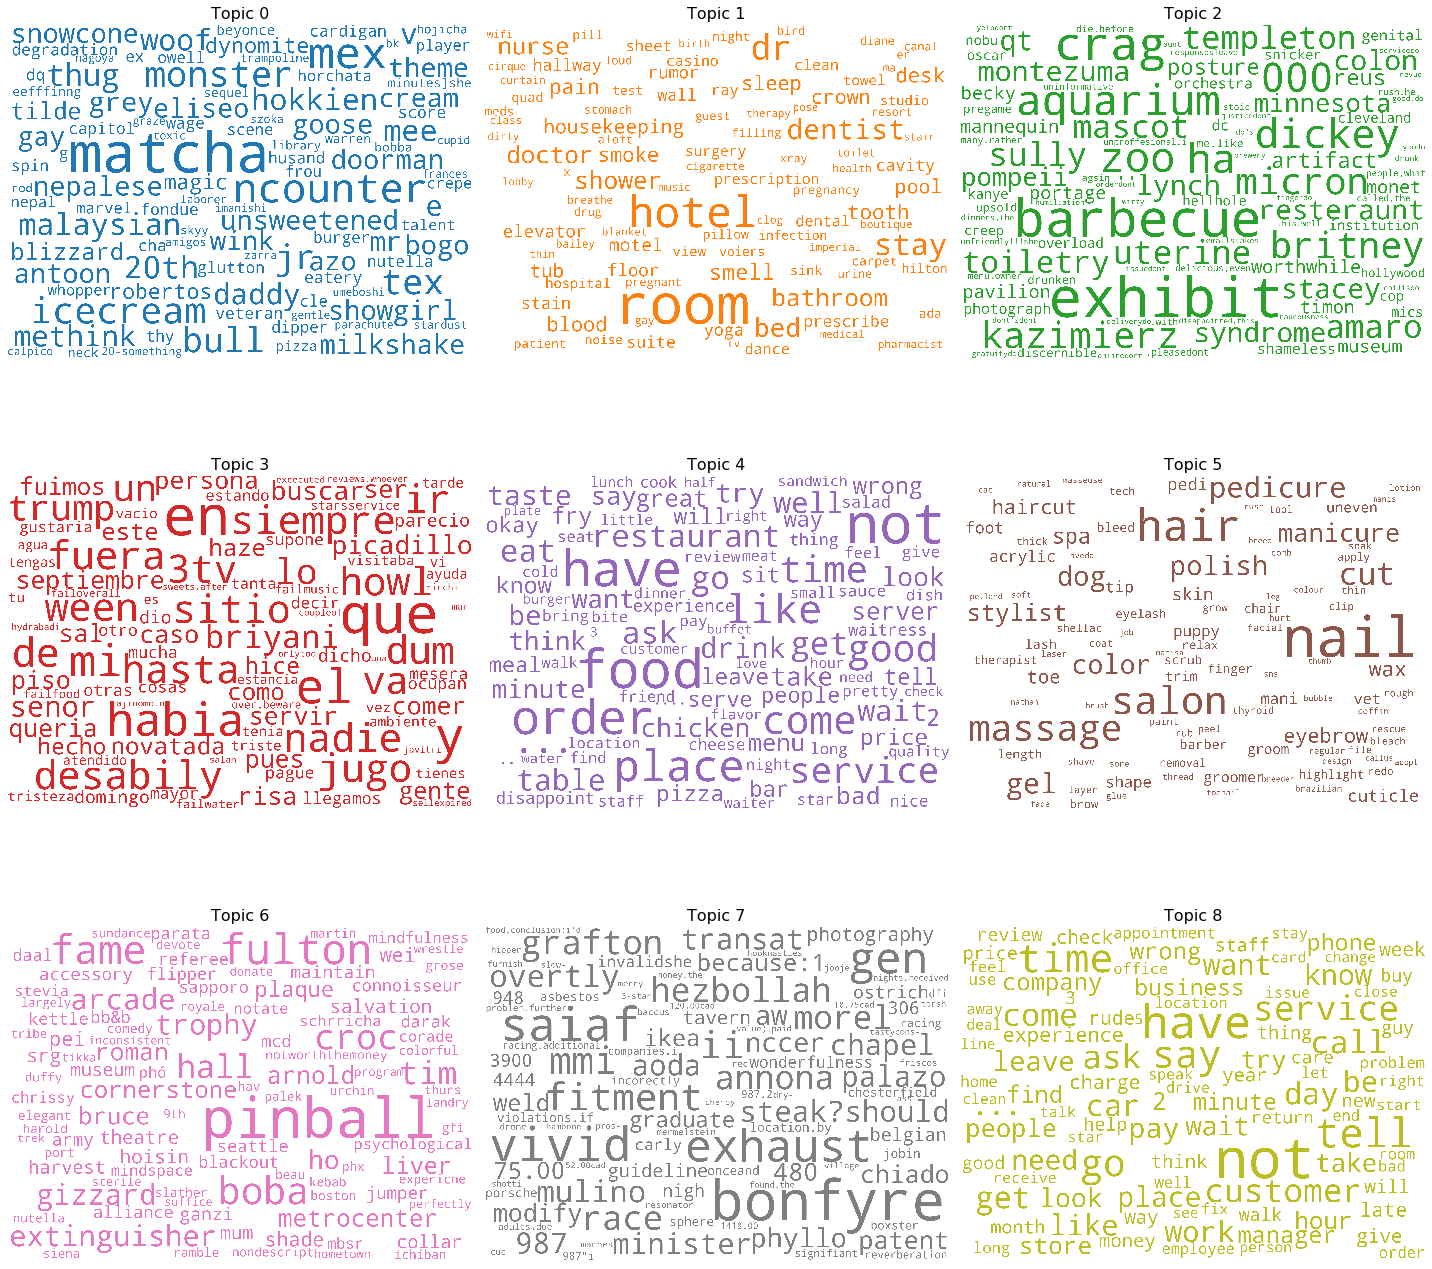

In [141]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

stopwords = set(STOPWORDS)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_words = 500, formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Wordcloud of the whole negative set. We can see that customer service keeps being a recurring theme.

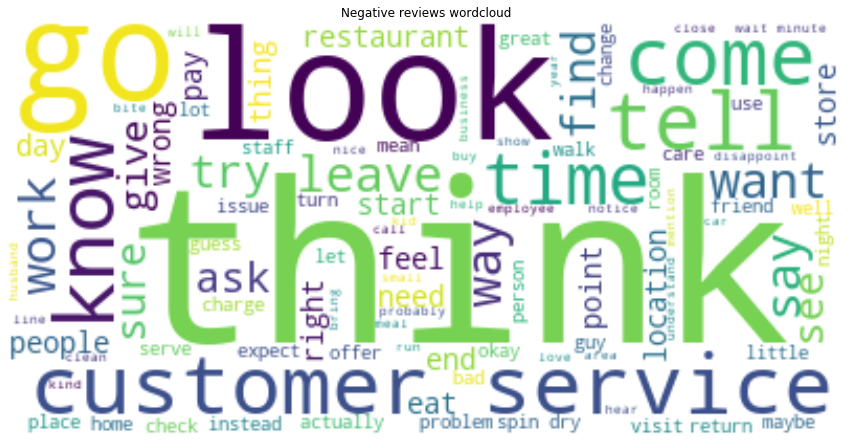

In [7]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

cloud = " ".join(r for review in train_neg_tokens for r in review)
wordcloud = WordCloud(max_words=100,background_color="white").generate(cloud)

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
plt.axis("off")
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_title('Negative reviews wordcloud')

plt.show()

## Positive comments

Its difficult to find a clear topic with this amount of training.  
Topic 6 seems to talk about sweet food, topic 7 about fast food, and topics 1 and 2 share customer service and good ambience.

In [5]:
#Build best model
lda_model = gensim.models.LdaMulticore(corpus=pos_corpus,
                                       id2word=pos_dictionary,
                                       num_topics=10, 
                                       random_state=91,
                                       chunksize=2000,
                                       passes=100,
                                       alpha=0.1,
                                       eta=0.8,
                                       per_word_topics=True)

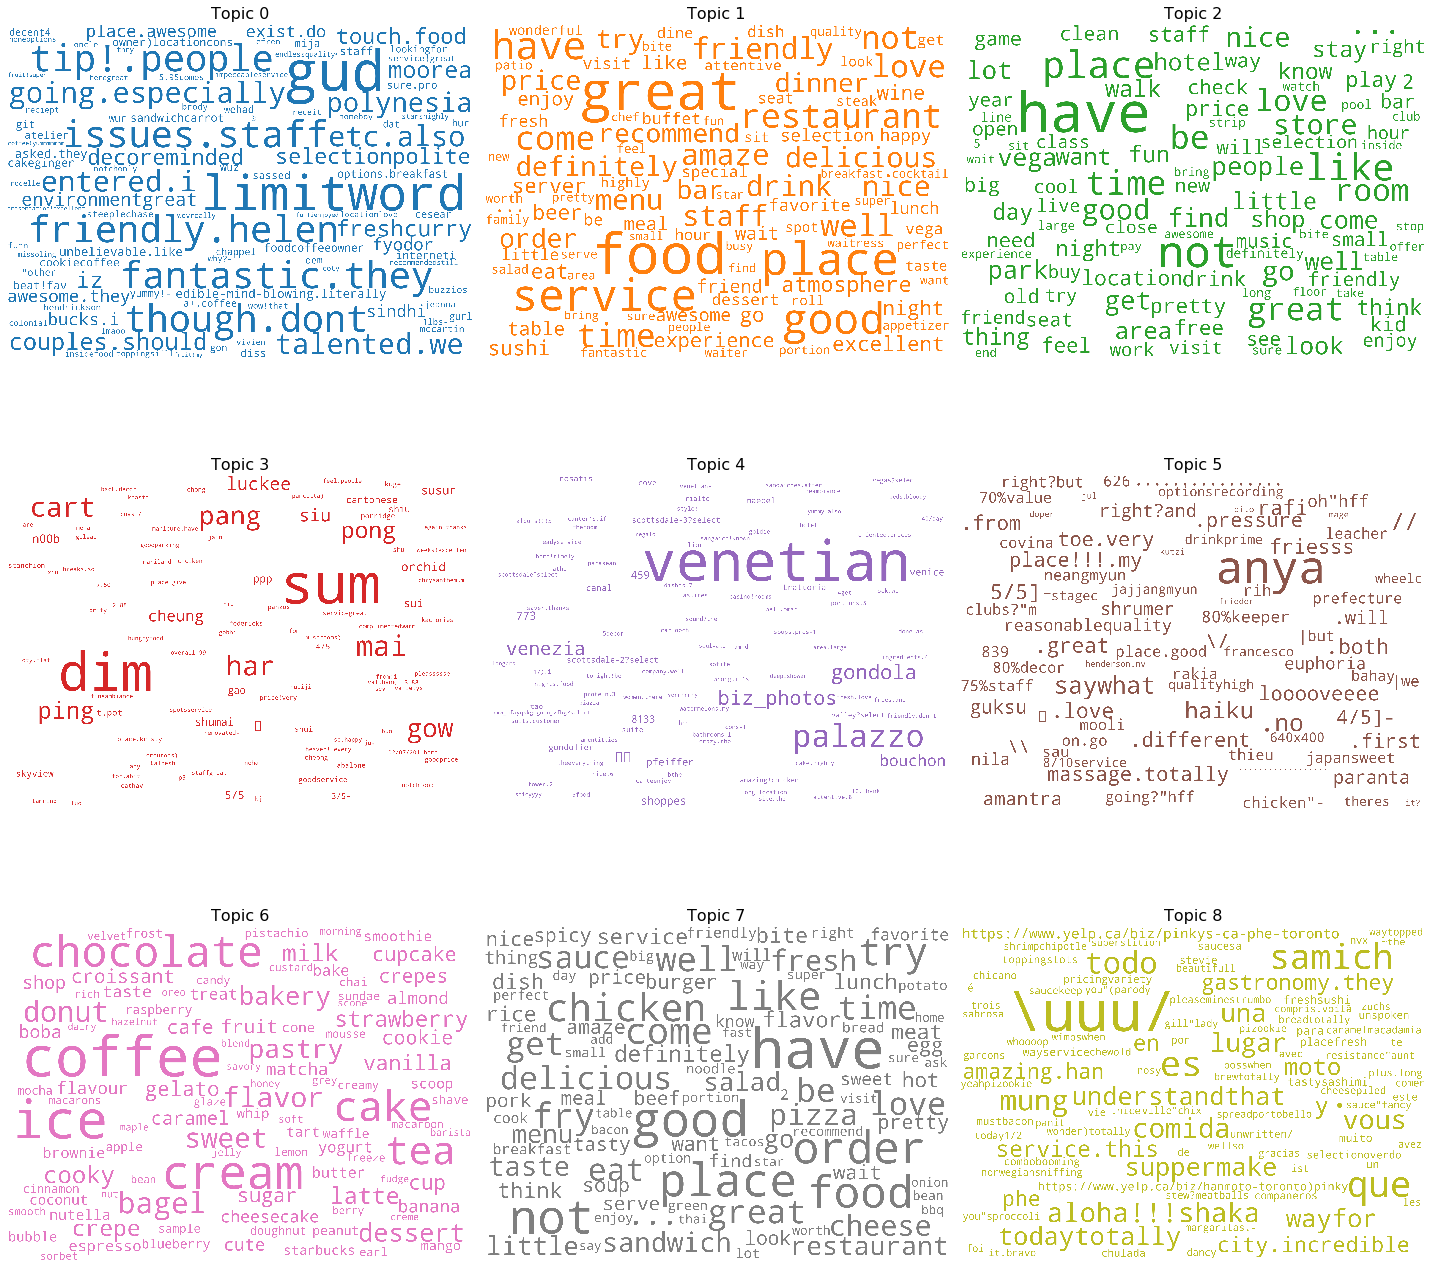

In [8]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
%matplotlib inline

stopwords = set(STOPWORDS)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_words = 500, formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Again, customer service is central in the word cloud of the positive comments.

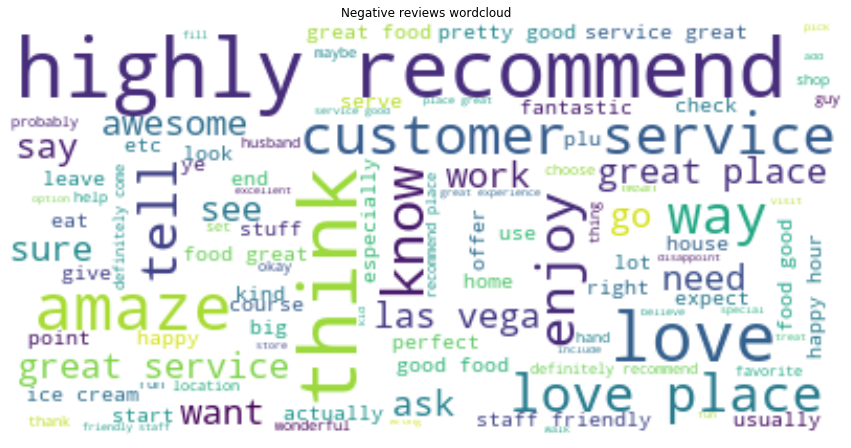

In [7]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

cloud = " ".join(r for review in train_pos_tokens for r in review)
wordcloud = WordCloud(max_words=100,background_color="white").generate(cloud)

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
plt.axis("off")
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_title('Negative reviews wordcloud')

plt.show()